# <u><center>Boardgame Recommender System<center></u>

*The recommender system is dedicated to all board-game lovers who want to find new game recommendations based on their preference. Users will be asked to input their favourite and least favorite games, and number of players they have. According to given information the program will suggest a new game to try.*

<center>Group 23</center>

| UID | Name |
|-----|------|
| 3035240415 | Min Woo Lee |
| 3035444372 | Togzhan Talgatkyzy |


---


##Introduction


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

module_dir = (
    "/content/drive/My Drive/COMP3359_Project/"
)

import sys
sys.path.append(module_dir)

Mounted at /content/drive


<u>Library to be used</u>

Surprise is Python Scikit library that builds and analyzes recommender system with explicit rating data. It gives access to matrix factor when we use SVD algorithm to visualize similarities between games. Surprise is very similar to Scikit-learn library, however, is more suitable for recommendation systems.

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 3.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617588 sha256=ae1633dff88902e5b505a82adf053ac22898e4aa45f3a0ce85af4b02c2c1b475
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

import os
import random
import numpy as np
import pandas as pd

---
##Data
 
The data used for the project contains game information and reviews about games from the BoardGameGeek website retrieved from kaggle.com.
The link to dataset:
https://www.kaggle.com/jvanelteren/boardgamegeek-reviews?select=games_detailed_info.csv

 
Below we have loaded data in Dataframe.

In [ ]:
data_dir = os.path.join(module_dir, "dataset/")
data_path = os.path.join(data_dir, "boardgame_dataset.csv")
list_path = os.path.join(data_dir, "boardgame_lists.csv")

names = ['username', 'userID', 'userRating', 'boardgameID','boardgame_name','alternate','minplayers','maxplayers','playingtime','minimum_age','boardgame_category','boardgame_mechanic']
data_df = pd.read_csv(data_path, names=names, header=0, low_memory = False)

print("Example Data:")
data_df = data_df.loc[0:,['userID','boardgameID','userRating']]
data_df.head(5)

Example Data:


,userID,boardgameID,userRating
0,0,0,10
1,1,0,10
2,2,0,10
3,3,0,10
4,4,0,10


---
##Model Implementation

###Content-based Filtering

Content-based filtering uses item features to recommend other items similar to user's preference. Items are compared based on similarities. 

In our project, system takes game features vector and user's preferences vector to calculate similarity matrix. Content-based filtering has the following advantages and disadvantages.

Advantages:
- easier to scale to a large number of users
- can capture specific interests of users and recommend niche items that nobody has rated

Disadvantages:
- technique requires a lot of domain knowledge
- can make recommendations based on user preference, thus, it is limited to information inputted by the user

In [ ]:
raw_data = np.array(data_df, dtype=int)

n_users= np.max(raw_data[:,0])
n_boardgames= np.max(raw_data[:,1])

shape = (n_users+1,n_boardgames+1)
shape

(1000, 100)

This means there are total 1000 unique users and 100 unique boardgames, now we are going to create adjacency matrix using this shape, and if a specific user has rated a specific boardgame, the value will be given.

In [ ]:
adj_matrix = np.ndarray(shape,dtype=int)

for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix[i])):
        adj_matrix[i][j] = 0

for userID,boardgameID,userRating in raw_data:
  adj_matrix[userID][boardgameID] = userRating
adj_matrix

array([[10, 10, 10, ...,  0,  7,  0],
       [10,  0,  0, ...,  0,  7,  0],
       [10,  0, 10, ..., 10,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  7,  0],
       [ 0,  0,  0, ...,  8,  0,  0]])

---
####<u>Euclidean Distance</u>

We are going to calculate the euclidean distance to recommend

$$euclidean = \sqrt{\sum_{d=1}^{D}(A_i - B_i)^2}$$

* lower the distance (smaller value), more similar user


In [ ]:
my_id, my_vector =0, adj_matrix[0]
best_match, best_match_id,best_match_vector = 9999, -1, []

for user_id,user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector-user_vector)))
    if euclidean_dist < best_match:
      best_match = euclidean_dist
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match,best_match_id))

Best Match: 50.586559479766954, Best Match ID: 411


In [ ]:
recommend_list = []
for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1,log2 = log
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[5, 16, 17, 35, 38, 44, 57, 69, 74, 83, 97]


---
####<u>Cosine Similarity</u>

Cosine Similarity measures how similar two items are. It is done my calculating cosine angle between two vectors in multi-dimensional space. 

\begin{equation}
cos \theta = \frac{A \cdot B}{||A|| \times ||B||}
\end{equation}


Consequently, output 1 means that two items are 100% similar, while 0-not similar.


In [ ]:
def compute_cos_similarity(v1,v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1,v2)
  return dot/(norm1*norm2)

In [ ]:
my_id, my_vector =0, adj_matrix[0]
best_match, best_match_id,best_match_vector = -1, -1, []

for user_id,user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    if cos_similarity > best_match:
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match,best_match_id))

Best Match: 0.7010557756500094, Best Match ID: 411


In [ ]:
recommend_list=[]
for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1,log2 = log
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[5, 16, 17, 35, 38, 44, 57, 69, 74, 83, 97]


**Why Cosine Similarity?**

For our hybrid model, we have decided to use cosine similarity. Cosine Similarity is mostly used when working with textual data represented by words. Euclidean distance meausures the distance between points, while cosine-angle. Both methods are applicable in recommender system, however, what if the distance between points is too large? Cosine Similarity is better approach because it takes into account the direction of vectors. So that even though the distance between preferences of users is too large, if their vectors are in the same direction they have similar taste.

---
###Collaborative Filtering

Collaborative filtering takes users with similar tastes and makes recommendation based on their reviews.  

Collaborative filtering has the following advantages and disadvantages.

Advantages:
- No domain knowledge necessary
- can help users discover new interests

Disadvantages:
- Cannot handle fresh items
- Hard to include side features for query/item


In [ ]:
from surprise import KNNBasic, SVD, SVDpp, NMF

reader = Reader(rating_scale=(5, 10))
data_df = Dataset.load_from_df(data_df, reader)

For collaborative filtering, we have tested four different models:
1. K-nearest neighbors (KNN)
2. Singular Value Decomposition (SVD)
3. Non-negative matrix factorization (NMF)
4. SVD++

---
####<u>KNN</u> 

Measures how likely a data point to be a part of a group of other data points it’s close to.

In [ ]:
model = KNNBasic()
cross_validate(model, data_df,measures=['rmse','mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6903  0.6842  0.6766  0.6755  0.6899  0.6833  0.0063  
MAE (testset)     0.5689  0.5664  0.5551  0.5601  0.5616  0.5624  0.0048  
Fit time          0.26    0.35    0.32    0.17    0.22    0.26    0.06    
Test time         2.00    1.81    1.54    1.50    1.07    1.58    0.31    


{'fit_time': (0.2553257942199707,
  0.3459811210632324,
  0.32048869132995605,
  0.17162156105041504,
  0.21848130226135254),
 'test_mae': array([0.56885165, 0.56635403, 0.5550806 , 0.56008557, 0.5615769 ]),
 'test_rmse': array([0.69029852, 0.68417643, 0.6765623 , 0.67551985, 0.68986223]),
 'test_time': (1.997424602508545,
  1.8091340065002441,
  1.5399878025054932,
  1.4982445240020752,
  1.0732860565185547)}

**Cross Validation**

Cross Validation is a technique used for evaluation by splitting the data into n subsets so that n-1 subsets are used for training and 1 for testing. It is done in order to avoid overfitting.

In order to evaluate accuracy of different models we rely on RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), Fit Test and Test Time.
Both MAE and RMSE range from 0 to infinity, but RMSE will not be as small as MAE. The smaller the value of both metrics-more accurate is model. The main difference of this two metrics is that MAE does not penalize huge errors, while RMSE does. By definition, RMSE is more useful when large errors are particularly undesirable. 

---
####<u>SVD</u>

Matrix factorization method that generalizes the eigendecomposition of a square matrix (n x n) to any matrix (n x m)

In [ ]:
model = SVD()
cross_validate(model, data_df,measures=['rmse','mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6653  0.6602  0.6666  0.6804  0.6783  0.6701  0.0078  
MAE (testset)     0.5442  0.5372  0.5426  0.5527  0.5510  0.5455  0.0057  
Fit time          1.62    2.09    2.19    1.85    1.21    1.79    0.35    
Test time         0.07    0.07    0.07    0.03    0.02    0.05    0.02    


{'fit_time': (1.622795820236206,
  2.093930721282959,
  2.1904730796813965,
  1.8453097343444824,
  1.2136189937591553),
 'test_mae': array([0.54422441, 0.53717535, 0.54262837, 0.55268648, 0.55100835]),
 'test_rmse': array([0.66526619, 0.66015328, 0.6665878 , 0.68038406, 0.67825498]),
 'test_time': (0.0739753246307373,
  0.06891512870788574,
  0.07453131675720215,
  0.03245186805725098,
  0.021379709243774414)}

---
####<u>NMF</u>

Shows data into lower dimensional spaces and decreases the number of features, but takes basis information needed.

In [ ]:
model = NMF()
cross_validate(model, data_df,measures=['rmse','mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.7313  2.7373  2.7098  2.7614  2.8181  2.7516  0.0371  
MAE (testset)     2.6110  2.6210  2.5903  2.6461  2.6980  2.6333  0.0370  
Fit time          2.02    2.15    2.43    2.00    1.41    2.00    0.33    
Test time         0.07    0.06    0.03    0.03    0.02    0.04    0.02    


{'fit_time': (2.017699956893921,
  2.14568829536438,
  2.4295084476470947,
  2.004340648651123,
  1.4129912853240967),
 'test_mae': array([2.61096214, 2.62099425, 2.59034423, 2.64609853, 2.69804329]),
 'test_rmse': array([2.73131848, 2.73725081, 2.70984836, 2.76136209, 2.8181378 ]),
 'test_time': (0.07431411743164062,
  0.06427001953125,
  0.02685999870300293,
  0.027869462966918945,
  0.016295433044433594)}

---
####<u>SVD++</u>

A derivative model of SVD, it gives better results in recommendation accuracy by adding quantitative data of user feedback such as boardgames that a user has evaluated.


In [ ]:
model = SVDpp()
cross_validate(model, data_df,measures=['rmse','mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6682  0.6681  0.6562  0.6618  0.6643  0.6637  0.0045  
MAE (testset)     0.5383  0.5405  0.5345  0.5342  0.5433  0.5381  0.0035  
Fit time          13.10   13.82   13.85   13.57   4.71    11.81   3.56    
Test time         0.32    0.33    0.26    0.17    0.10    0.24    0.09    


{'fit_time': (13.09838056564331,
  13.823722124099731,
  13.849650621414185,
  13.56598949432373,
  4.713750123977661),
 'test_mae': array([0.53827725, 0.54045595, 0.53447524, 0.53417753, 0.5433008 ]),
 'test_rmse': array([0.66824898, 0.66811143, 0.65615756, 0.66180268, 0.66430405]),
 'test_time': (0.3151390552520752,
  0.3294870853424072,
  0.25989198684692383,
  0.1743919849395752,
  0.0980989933013916)}

**Comparison Table**

|      | Mean RMSE | Mean MAE | Fit time | Test time | 
|------|----------|--------------|-----|-----| 
| KNN | 0.68 | 0.56 | 0.14 | 1.19 |
| SVD | 0.67 | 0.54 | 1.79 | 0.05 |
| NMF | 2.76 | 2.65 | 1.76 | 0.03 |
| SVD++ | 0.66 | 0.54 | 10.73 | 0.24 |


We have selected SVD and NMF for our models because with large data, the prediction stage might be slow for KNN, and KNN is sensitive to the scale of the data and irrelevant features. We also ignored SVD++ due to its high fit time.

---
###Hybrid Filtering

For our model, we are using Collaborative Filtering to do embedding first and then Content-based Filtering to recommend boardgames. The advantage of hybrid filtering is that it allows to overcome disadvantages of both filtering methods and get more precise recommendations.

Here we are going to compare four different hybrid filtering models - two of them are using radomized SVD and the other two are using non-negative matrix factorization. While all of them are using cosine similarity for content-based filtering, two of them will be based on users, and the other two will be based on boardgame to calculate the similarity. 

In [ ]:
import numpy as np
from sklearn.decomposition import randomized_svd, non_negative_factorization
from surprise import Dataset

---
####<u>Hybrid 1</u>

Collaborative : randomized SVD

Content-based : cos similarity (user-based)

In [ ]:
U, S, V = randomized_svd(adj_matrix, n_components=2)
S = np.diag(S)

In [ ]:
print(U.shape)
print(S.shape)
print(V.shape)

(1000, 2)
(2, 2)
(2, 100)


In [ ]:
np.matmul(np.matmul(U,S),V)

array([[ 8.66129953,  4.38381109,  3.05201282, ...,  6.86856184,
         7.405342  ,  3.65475237],
       [ 1.3113225 ,  0.80108266,  0.67398959, ...,  1.11243602,
         1.16452344,  0.50549736],
       [ 3.69852343,  5.3636681 ,  6.68964308, ...,  4.77665363,
         4.26414764,  0.34483799],
       ...,
       [ 0.13449168, -0.11146957, -0.22957239, ...,  0.01185464,
         0.0583284 ,  0.11926631],
       [ 2.0302364 , -0.23923714, -1.23881723, ...,  0.94111952,
         1.33604412,  1.29778832],
       [ 1.89476658,  0.30592288, -0.33980544, ...,  1.15774406,
         1.41390306,  1.02692685]])

In [ ]:
def hybrid1(userid):

  my_id, my_vector =userid, U[userid]
  best_match, best_match_id,best_match_vector = -1, -1, []

  for user_id,user_vector in enumerate(U):
    if my_id != user_id:
      cos_similarity = compute_cos_similarity(my_vector, user_vector)
      if cos_similarity > best_match:
        best_match = cos_similarity
        best_match_id = user_id
        best_match_vector = user_vector

  recommend_list=[]
  for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
    log1,log2 = log
    if log1 < 1 and log2 > 0:
      recommend_list.append(i)
  
  return best_match, best_match_id, recommend_list

best_match, best_match_id, recommend_list = hybrid1(0)
print('Best Match: {}, Best Match ID: {}'.format(best_match,best_match_id))
print('List length: {}, Recommended boardgames: {}'.format(len(recommend_list), recommend_list))

Best Match: 0.9999997771501534, Best Match ID: 330
List length: 1, Recommended boardgames: [18]


---
####<u>Hybrid 2</u>

Collaborative : randomized SVD

Content-based : cos similarity (boardgame-based)

In [ ]:
def hybrid2(boardgameid):
  #Since U is decomposed, you need to transpose
  my_id, my_vector =boardgameid, V.T[boardgameid]
  best_match, best_match_id,best_match_vector = -1, -1, []

  for user_id,user_vector in enumerate(V.T):
    if my_id != user_id:
      cos_similarity = compute_cos_similarity(my_vector, user_vector)
      if cos_similarity > best_match:
        best_match = cos_similarity
        best_match_id = user_id
        best_match_vector = user_vector

  recommend_list = []
  for i, user_vector in enumerate(adj_matrix):
    if adj_matrix[i][my_id]>8:
      recommend_list.append(i)

  return best_match, best_match_id, recommend_list

best_match, best_match_id, recommend_list = hybrid2(0)
print('Best Match: {}, Best Match ID: {}'.format(best_match,best_match_id))
print('List length: {}, Recommended users: {}'.format(len(recommend_list), recommend_list))

Best Match: 0.9999918267983118, Best Match ID: 35
List length: 229, Recommended users: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 107, 136, 162, 199, 200, 242, 256, 292, 302, 308, 310, 311, 312, 315, 320, 326, 329, 333, 335, 338, 342, 343, 349, 350, 351, 359, 360, 363, 365, 366, 368, 378, 381, 388, 392, 394, 403, 404, 406, 421, 422, 428, 429, 430, 431, 438, 442, 446, 450, 458, 461, 474, 490, 506, 507, 543, 550, 554, 555, 557, 561, 568, 572, 578, 590, 593, 598, 602, 604, 606, 608, 620, 622, 625, 630, 634, 661, 666, 670, 673, 675, 678, 687, 688, 692, 693, 695, 697, 698, 699, 708, 710, 713, 715, 724, 743, 752, 766, 782, 806, 847, 849, 850, 851, 85

---
####<u>Hybrid 3</u>

Collaborative : non-negative matrix factorization

Content-based : cos similarity (user-based)

In [ ]:
A, B, iter = non_negative_factorization(adj_matrix, n_components=2)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)


In [ ]:
np.matmul(A,B)

array([[8.3176389 , 4.68344865, 5.27297969, ..., 6.49245848, 6.91399679,
        3.80855522],
       [1.2543282 , 0.92631341, 1.04291349, ..., 1.11811967, 1.13529002,
        0.47670569],
       [3.73139892, 5.19896526, 5.85338718, ..., 4.87010939, 4.40595191,
        0.33390351],
       ...,
       [0.16944617, 0.        , 0.        , ..., 0.07197554, 0.10068261,
        0.119925  ],
       [1.93387807, 0.        , 0.        , ..., 0.82145208, 1.14908405,
        1.36869615],
       [1.77736585, 0.3713991 , 0.41814912, ..., 0.9896504 , 1.21244858,
        1.09312095]])

In [ ]:
def hybrid3(userid):
  my_id, my_vector =userid, A[userid]
  best_match, best_match_id,best_match_vector = -1, -1, []

  for user_id,user_vector in enumerate(A):
    if my_id != user_id:
      cos_similarity = compute_cos_similarity(my_vector, user_vector)
      if cos_similarity > best_match:
        best_match = cos_similarity
        best_match_id = user_id
        best_match_vector = user_vector

  recommend_list = []
  for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
    log1,log2 = log
    if log1 < 1 and log2 > 0:
      recommend_list.append(i)

  return best_match, best_match_id, recommend_list

best_match, best_match_id, recommend_list = hybrid3(0)
print('Best Match: {}, Best Match ID: {}'.format(best_match,best_match_id))
print('List length: {}, Recommended boardgames: {}'.format(len(recommend_list), recommend_list))

Best Match: 0.9999997989909756, Best Match ID: 351
List length: 20, Recommended boardgames: [5, 8, 16, 17, 22, 28, 30, 38, 40, 42, 46, 50, 60, 62, 69, 72, 83, 84, 96, 97]


---
####<u>Hybrid 4</u>

Collaborative : non-negative matrix factorization

Content-based : cos similarity (boardgame-based)

In [ ]:
def hybrid4(boardgameid):
  my_id, my_vector =boardgameid, B.T[boardgameid]
  best_match, best_match_id,best_match_vector = -1, -1, []

  for user_id,user_vector in enumerate(B.T):
    if my_id != user_id:
      cos_similarity = compute_cos_similarity(my_vector, user_vector)
      if cos_similarity > best_match:
        best_match = cos_similarity
        best_match_id = user_id
        best_match_vector = user_vector

  recommend_list = []
  for i, user_vector in enumerate(adj_matrix):
    if adj_matrix[i][my_id]>0:
      recommend_list.append(i)
      
  return best_match, best_match_id, recommend_list

best_match, best_match_id, recommend_list = hybrid4(0)
print('Best Match: {}, Best Match ID: {}'.format(best_match,best_match_id))
print('List length: {}, Recommended users: {}'.format(len(recommend_list), recommend_list))

Best Match: 0.9999251252397281, Best Match ID: 35
List length: 229, Recommended users: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 107, 136, 162, 199, 200, 242, 256, 292, 302, 308, 310, 311, 312, 315, 320, 326, 329, 333, 335, 338, 342, 343, 349, 350, 351, 359, 360, 363, 365, 366, 368, 378, 381, 388, 392, 394, 403, 404, 406, 421, 422, 428, 429, 430, 431, 438, 442, 446, 450, 458, 461, 474, 490, 506, 507, 543, 550, 554, 555, 557, 561, 568, 572, 578, 590, 593, 598, 602, 604, 606, 608, 620, 622, 625, 630, 634, 661, 666, 670, 673, 675, 678, 687, 688, 692, 693, 695, 697, 698, 699, 708, 710, 713, 715, 724, 743, 752, 766, 782, 806, 847, 849, 850, 851, 85

---
##Preliminary Experimental Results



###Experiment 1
|      | cos similarity | Best Match ID | Length of Recommend List |
|------|----------|--------------|-----|
| Hybrid 1 | <center>0.9999 | <center>330 | <center>1 |
| Hybrid 2 | <center>0.9999 | <center>35 | <center>151 |
| Hybrid 3 | <center>0.9999 | <center>351 | <center>20 |
| Hybrid 4 | <center>0.9999 | <center>35 | <center>151 |

This is the result we get when we set user id as 0 for Hybrid model 1 and 3, and boardgame id as 0 for model 2 and 4. As you can see, cos similiarity is extremly high (when we only used content-based filtering the cosine similarity was only 0.7), but best match id are different for user-approach models (Hybrid model 1 and 3), but same for boargame-approach models (Hybrid model 2 and 4). Therefore, we tried other ids to see whether best match IDs are still different and whether hybrid model 2 and 4 gives the same result every time. 

###Experiment 2
when user_id = 1, boardgame_id = 1:

|      | Best Match ID | Length of Recommend List |
|------|--------------|-----|
| Hybrid 1 | <center>972 | <center>7 |
| Hybrid 2 | <center>8 | <center>152 |
| Hybrid 3 | <center>710 | <center>36 |
| Hybrid 4 | <center>2 | <center>152 |

when user_id = 2, boardgame_id = 2:

|      | Best Match ID | Length of Recommend List |
|------|--------------|-----|
| Hybrid 1 | <center>430 | <center>7 |
| Hybrid 2 | <center>8 | <center>152 |
| Hybrid 3 | <center>677 | <center>0 |
| Hybrid 4 | <center>1 | <center>171 |

when user_id = 3, boardgame_id = 3:

|      | Best Match ID | Length of Recommend List |
|------|--------------|-----|
| Hybrid 1 | <center>43 | <center>5 |
| Hybrid 2 | <center>55 | <center>163 |
| Hybrid 3 | <center>400 | <center>13 |
| Hybrid 4 | <center>66 | <center>163 |

when user_id = 4, boardgame_id = 4:

|      | Best Match ID | Length of Recommend List |
|------|--------------|-----|
| Hybrid 1 | <center>395 | <center>7 |
| Hybrid 2 | <center>59 | <center>197 |
| Hybrid 3 | <center>483 | <center>3 |
| Hybrid 4 | <center>77 | <center>197 |

Hybrid model 1 and 3 give the best match USER ID, while model 2 and 4 give the best match BOARDGAME ID. Therefore, the recommended list of model 1 and 3 are list of boardgames enjoyed by best matched user, and the list give by model 2 and 4 are list of users who enjoyed the best matched boardgame.

For our application, we need a recommended list of boardgame, so we deicided to ignore the recommended lists provided by model 2 and 4. Also, we realized sometimes, model 1 and 3 will give you the best match user id, but the recommended list is empty. This is mainly because the user and the best matched user only played the same games; they have the exactly same experience. Therefore, we have decided to append the best matched boardgame Id to the final recommendation list to avoid empty list. 

Now, we are going to choose one model from Hybrid model 1 and 3, and one from Hybrid model 2 and 4. The next experiment shows an evaluation metrics for the selection. 

###Experiment 3

We are going to choose One model between Hybrid model 1 and 3. The only difference of these two models is the collaborative filtering method: model 1 uses SVD, and model 2 uses NMF. 

We are going to evaluate 100 random user_id(10% of dataset) from the dataset, for each run, the model will return the best match, and we are going to compare those two ids with manhatten distance to see how similar they are. 

Since we are running the models 10 times each, there will be a list and we are going to compare two models by looking and mean and std. 

In [ ]:
import random

test_inputs = random.sample(range(1000), 100)

In [ ]:
from math import*
 
def manhattan_distance(x,y):
    return abs(x-y)

In [ ]:
hybrid1_result = []
hybrid3_result = []

for i in range(100):
  _, hybrid1_output, _ = hybrid1(test_inputs[i])
  _, hybrid3_output, _ = hybrid3(test_inputs[i])
  hybrid1_result.append(hybrid1_output)
  hybrid3_result.append(hybrid3_output)

hybrid1_manhattan = []
hybrid3_manhattan = []

for i in range(100):
  hybrid1_manhattan.append(manhattan_distance(test_inputs[i],hybrid1_result[i]))
  hybrid3_manhattan.append(manhattan_distance(test_inputs[i],hybrid3_result[i]))

print('Hybrid Model 1')
print('Average mean of Manhattan Distance: {}, Std: {}'.format(np.average(hybrid1_manhattan), np.std(hybrid1_manhattan)))

print('Hybrid Model 3')
print('Average mean of Manhattan Distance: {}, Std: {}'.format(np.average(hybrid3_manhattan), np.std(hybrid3_manhattan)))

Hybrid Model 1
Average mean of Manhattan Distance: 295.67, Std: 238.63310981504642
Hybrid Model 3
Average mean of Manhattan Distance: 444.06, Std: 285.37364349217677


Since Hybrid model 1 gives us much lower manhattan distance with smaller standard deviation. Hence, we decided to use model 1.

###Experiment 4

Here we are going to choose the appropriate model for boardgame-based recommended item. We took random 10 boardgame_ids (10% of our dataset) to compare the performance of two models. We will have a list of 10 cosine similarity results, and we are going to compare their mean and standard deviation. 

In [ ]:
test_inputs2 = random.sample(range(100), 10)

hybrid2_result = []
hybrid4_result = []

for i in range(10):
  hybrid2_output, _,_, = hybrid2(test_inputs2[i])
  hybrid4_output, _,_, = hybrid4(test_inputs2[i])
  hybrid2_result.append(hybrid2_output)
  hybrid4_result.append(hybrid4_output)

print('Hybrid Model 2')
print('Average mean of Cosine Similarity: {}, Std: {}'.format(np.average(hybrid2_result), np.std(hybrid2_result)))

print('Hybrid Model 4')
print('Average mean of Cosine Similarity: {}, Std: {}'.format(np.average(hybrid4_result), np.std(hybrid4_result)))

Hybrid Model 2
Average mean of Cosine Similarity: 0.9999928131452522, Std: 7.892302932792937e-06
Hybrid Model 4
Average mean of Cosine Similarity: 0.9999503136368773, Std: 6.41959085082021e-05


Since Hybrid model 2 gives us slightly higher average cosine similarity and lower standard deviation. We decided to use model 2.

Therefore, we have concluded that we are using a mixture of hybrid model 1 and model 2, they are both using SVD for collaborative filtering and cosine similarity for content-based filtering. 

Below is the final recommend system. 

####Final Model

In [ ]:
def recommend (list, user, total):
  raw_data = np.array(data_df, dtype=int)
  shape = (1001,100)

  adj_matrix = np.ndarray(shape,dtype=int)

  for i in range(len(adj_matrix)):
      for j in range(len(adj_matrix[i])):
          adj_matrix[i][j] = 0

  for userID,boardgameID,userRating in raw_data:
    adj_matrix[userID][boardgameID] = userRating

  recommend_list=[]

  U, S, V = randomized_svd(adj_matrix, n_components=2)
  S = np.diag(S)
  np.matmul(np.matmul(U,S),V)

  my_id, my_vector =1000, U[1000]
  best_match, best_match_id,best_match_vector = -1, -1, []

  for user_id,user_vector in enumerate(U):
    if my_id != user_id:
      cos_similarity = compute_cos_similarity(my_vector, user_vector)
      if cos_similarity > best_match:
        best_match = cos_similarity
        best_match_id = user_id
        best_match_vector = user_vector
  for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
    log1,log2 = log
    if log1 < 1 and log2 > 8:
      recommend_list.append(i)
  #print('Best Match: {}, Best Match User ID: {}'.format(best_match,best_match_id))
  #print('List length: {}, Recommended boardgames before model 4: {}'.format(len(recommend_list), recommend_list))

  # here is a rated list of boardgame ids provided by users that is above 8(rating)
  rated_list = []
  for i in range(total):
    if user[i][1] >= 0:
      rated_list.append(user[i][1])

  for i in rated_list:
    my_id, my_vector = i, V.T[i]
    best_match, best_match_id,best_match_vector = -1, -1, []
    for user_id,user_vector in enumerate(V.T):
      if my_id != user_id:
        cos_similarity = compute_cos_similarity(my_vector, user_vector)
        if cos_similarity > best_match:
          best_match = cos_similarity
          best_match_id = user_id
          best_match_vector = user_vector
    #print('Best Match: {}, Best Match Boardgame ID: {}'.format(best_match,best_match_id))

    #check if it repeats with the ones already rated by the user
    if best_match_id not in rated_list:
      recommend_list.append(best_match_id)

  # remove duplicate
  unique_list = []
  for i in recommend_list:
    if i not in unique_list:
      unique_list.append(i)

  #print('List length: {}, Recommended boardgames: {}'.format(len(unique_list), unique_list))
  return unique_list


---
##Final Application

We are going to receive some ratings from the users. We will show the list of 100 board games, and let the user to choose the id of boardgame and give it a rating. Based on his or her rating, we are going to recommend a list of board games. As more ratings provided by the user, our model will become more accurate, so we are going to ask the user to input at least two ratings of different boardgames.

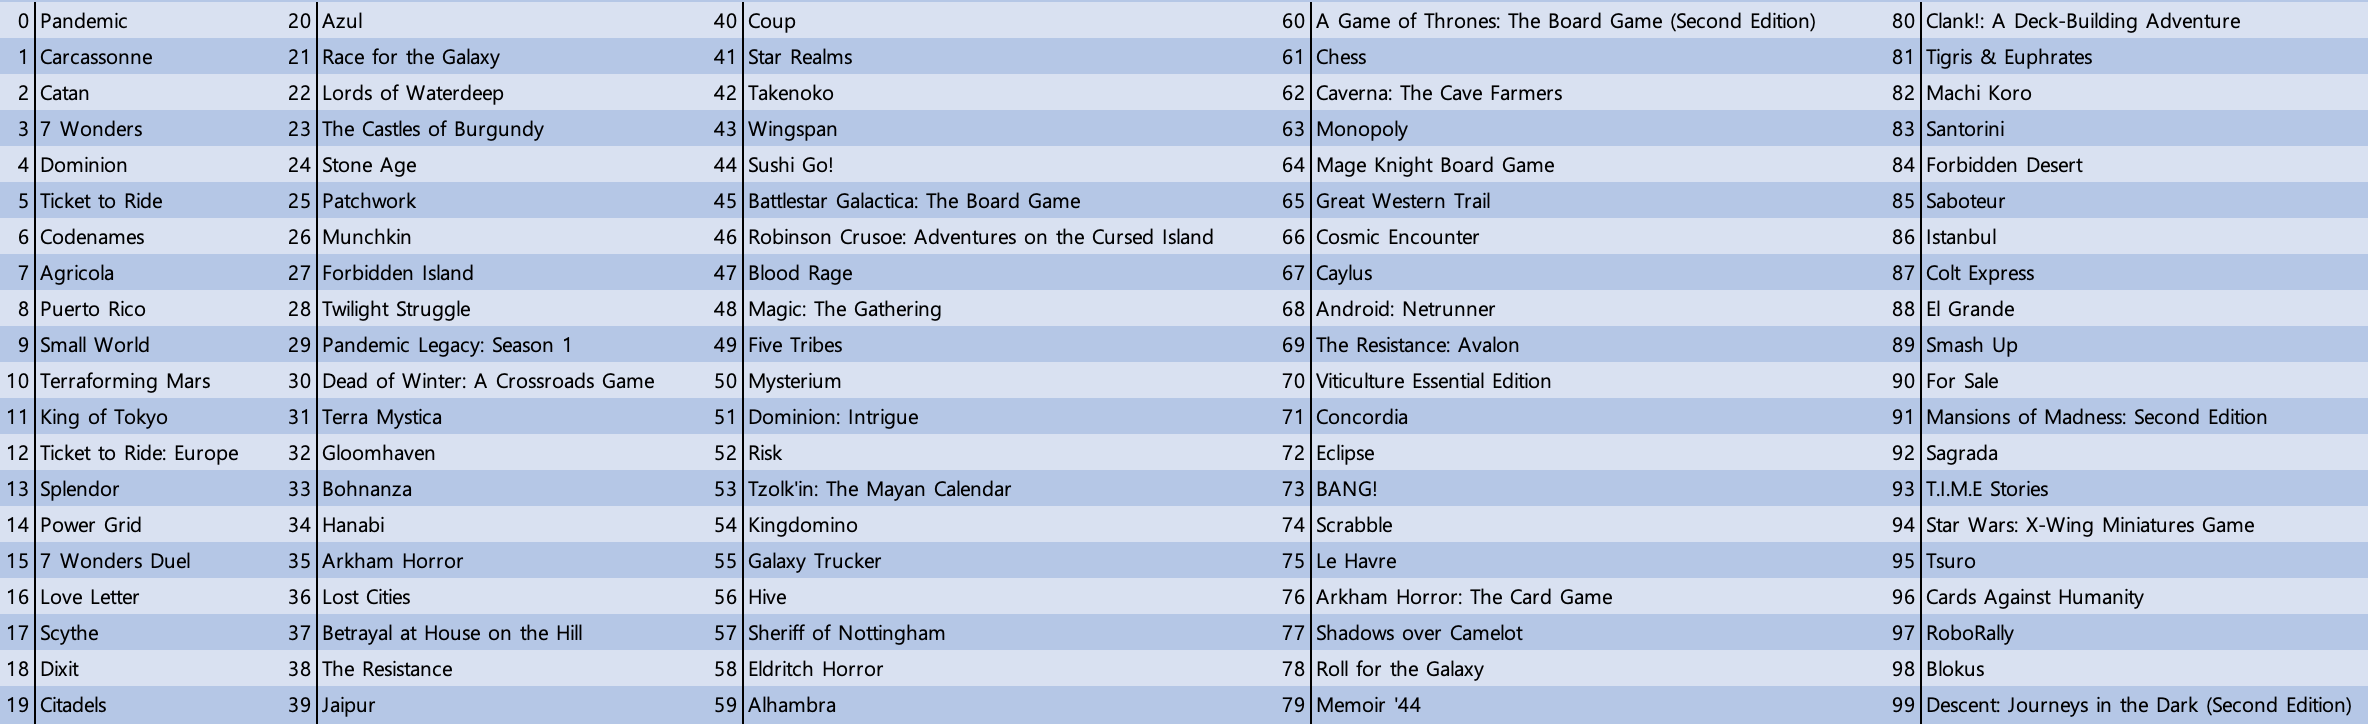



In [ ]:
data_df = pd.read_csv(data_path, names=names, header=0, low_memory = False)
data_df = data_df.loc[0:,['userID','boardgameID','userRating']]
names1 = ['boardgameID','boardgame_name']
list_df = pd.read_csv(list_path, names=names1, header=0, low_memory = False)

print("Above is the list of 100 board games please choose a board game and give us a rating (0-5)!")
print("Please provide ratings of at least 2 different boardgames for better match!")

total = input('How many ratings would like to give?')
ratings = [-1,-1,-1]
for i in range (int(total)):
   x = input('Choose a board game (id from 0 to 99):')
   y = input('Enter rating (value from 0 to 5)')
   rating = [1000, int(x), int(y)+5]
   data_df = np.vstack([data_df,rating])
   ratings = np.vstack([ratings,rating])

final_list = recommend(data_df, ratings, int(total))

# we are going to convert boardgameIDs to names
visualization = []

list_data = np.array(list_df)
list_ids = list_data[:,0].astype(int)

for i in final_list:
  for j in list_ids:
    if i == list_ids[j]:
      visualization.append(list_data[j][1])

print('Here is our recommendation: {}'.format(visualization))

Above is the list of 100 board games please choose a board game and give us a rating (0-5)!
Please provide ratings of at least 2 different boardgames for better match!
How many ratings would like to give?2
Choose a board game (id from 0 to 99):77
Enter rating (value from 0 to 5)5
Choose a board game (id from 0 to 99):66
Enter rating (value from 0 to 5)5
Here is our recommendation: ['Dominion', 'Ticket to Ride', 'Star Realms', 'Hive', 'Android: Netrunner', 'Sagrada', 'Alhambra']


---
##References:

Bondarenko, K. (2019, February 27). Similarity metrics in recommender systems. Retrieved March 31, 2021, from https://bond-kirill-alexandrovich.medium.com/similarity-metrics-in-recommender-systems-aed9d3b2315f

Javed, M. (2020, November 04). Using cosine similarity to build a movie recommendation system. Retrieved March 31, 2021, from https://towardsdatascience.com/using-cosine-similarity-to-build-a-movie-recommendation-system-ae7f20842599

Valencia, S. (2017, February 13). An introductory recommender systems tutorial. Retrieved March 31, 2021, from https://medium.com/ai-society/a-concise-recommender-systems-tutorial-fa40d5a9c0fa

Recommendation Systems. Retrieved March 31, 2021,
https://developers.google.com/machine-learning/recommendation/content-based/summary